In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import math
from sklearn import linear_model, decomposition, datasets
from sklearn import metrics

In [2]:
#retrieving the data
parkingdata = pd.read_csv("parking_duration_of_parking_event_vs_street_ID.csv")
parkingdata = parkingdata.sample(n=10000)
parkingdata.size

130000

In [3]:
#Converting all the feature attributes to uppercase for uniformity

parkingdata['Area Name'] = parkingdata['Area Name'].str.upper()
parkingdata['Street Name'] = parkingdata['Street Name'].str.upper()
parkingdata['Between Street 1'] = parkingdata['Between Street 1'].str.upper()
parkingdata['Between Street 2'] = parkingdata['Between Street 2'].str.upper()
parkingdata['Street Marker'] = parkingdata['Street Marker'].str.upper()
parkingdata['Sign'] = parkingdata['Sign'].str.upper()

parkingdata.head(5)

,Area Name,Street Name,Between Street 1,Between Street 2,Side Of Street,Street Marker,Arrival Time,Departure Time,Duration of Parking Event (in seconds),Sign,In Violation?,Street ID,Device ID
2941370,TITLES,LT LONSDALE STREET,QUEEN STREET,ELIZABETH STREET,3,3446N,21/12/2011 08:55:42 AM,21/12/2011 09:42:49 AM,2827,1P MTR M-SAT 7:30-19:30,0,926,1590
10805412,RIALTO,KING STREET,FLINDERS LANE,FLINDERS STREET,2,1390E,18/08/2012 03:58:11 PM,18/08/2012 03:59:23 PM,72,2P MTR SAT 7:30-20:30,0,839,5476
11555516,RACV,LT COLLINS STREET,WILLIAM STREET,QUEEN STREET,4,2223S,11/09/2012 08:40:38 AM,11/09/2012 08:42:16 AM,98,2P DIS M-SUN 0:00-23:59,0,911,5448
8713485,VICTORIA MARKET,VICTORIA STREET,O'CONNELL STREET,ELIZABETH STREET,3,7556N,17/06/2012 05:01:02 PM,17/06/2012 05:03:33 PM,151,2P SUN 7:30-18:30,0,1381,3887
6917731,MAGISTRATES,KING STREET,LT LONSDALE STREET,LONSDALE STREET,5,4453W,23/04/2012 10:28:40 AM,23/04/2012 10:31:35 AM,175,2P MTR M-F 10:00-16:00,0,839,897


In [4]:
#Removing all redundant extra whitespaces
for x in parkingdata.columns:
    if parkingdata[x].dtype == object:
        parkingdata[x] = parkingdata[x].str.strip()

In [5]:
#converting object to datetime
parkingdata['Arrival Time'] = pd.to_datetime(parkingdata['Arrival Time'])
parkingdata['Departure Time'] = pd.to_datetime(parkingdata['Departure Time'])

In [6]:
#Target field identification
duration = parkingdata['Duration of Parking Event (in seconds)'].copy()

print('Minimum parking duration (seconds): ' + str(duration.min()))
print('Maximum parking duration (seconds): ' + str(duration.max()))
print('\nMinimum parking duration (hour): ' + str(duration.min()/3600))
print('Maximum parking duration (hour): ' + str(duration.max()/3600))
print('\nMinimum parking duration is under [' + str(math.trunc(duration.min()/3600) + 1) + '] hours')
print('Maximum parking duration is under [' + str(math.trunc(duration.max()/3600) + 1) + '] hours')

durList = []
static = 1
df = pd.DataFrame()

for record in duration.values:
    hour = 3600
    index = 0
    while static == 1:
        if record < hour:
#             print("\nDuration in seconds: " + str(record))
            data = math.trunc(record/3600) + 1
            durList.append(data)
#             print("Duration is under " + str(data) + " hours")
            break
        else:
            hour += 3600

df.insert(0, 'Duration (Hours)', durList, True)
target = df['Duration (Hours)']
target.head(10)

Minimum parking duration (seconds): 4
Maximum parking duration (seconds): 55793

Minimum parking duration (hour): 0.0011111111111111111
Maximum parking duration (hour): 15.498055555555556

Minimum parking duration is under [1] hours
Maximum parking duration is under [16] hours


0    1
1    1
2    1
3    1
4    1
5    2
6    1
7    1
8    2
9    1
Name: Duration (Hours), dtype: int64

In [7]:
#Preliminary Target Features identification (Pre-Hill Climbing)

#Convert possible targets to dtype = int
intDf = parkingdata.copy()
#Drop useless fields
intDf.drop('Arrival Time', axis = 1, inplace = True)
intDf.drop('Departure Time', axis = 1, inplace = True)
intDf.drop('Street Marker', axis = 1, inplace = True)
#Drop target field
intDf.drop('Duration of Parking Event (in seconds)', axis = 1, inplace = True)
#Drop already int fields (Will add back after)
intDf.drop('In Violation?', axis = 1, inplace = True)
intDf.drop('Side Of Street', axis = 1, inplace = True)
intDf.drop('Street ID', axis = 1, inplace = True)
intDf.drop('Device ID', axis = 1, inplace = True)

#Transform the remainder non-int fields' values to unique int identifiers
for column in intDf:
    unique_vals = intDf[column].unique()
    intDf[column].replace(to_replace = unique_vals, value = list(range(len(unique_vals))), inplace = True)

#Create dataframe for all the relevant features
features = intDf.copy()

#Add back int fields (If not the target field)
features['In Violation?'] = parkingdata['In Violation?']
features['Side Of Street'] = parkingdata['Side Of Street']
features['Street ID'] = parkingdata['Street ID']
features['Device ID'] = parkingdata['Device ID']
#Add back datetime features with only the meaningful subset of data
features['Arrival Hour'] = parkingdata['Arrival Time'].dt.hour
features['Departure Hour'] = parkingdata['Departure Time'].dt.hour

#Table view of features dataframe
features.head(10)

,Area Name,Street Name,Between Street 1,Between Street 2,Sign,In Violation?,Side Of Street,Street ID,Device ID,Arrival Hour,Departure Hour
2941370,0,0,0,0,0,0,3,926,1590,8,9
10805412,1,1,1,1,1,0,2,839,5476,15,15
11555516,2,2,2,2,2,0,4,911,5448,8,8
8713485,3,3,3,0,3,0,3,1381,3887,17,17
6917731,4,1,4,3,4,0,5,839,897,10,10
1117909,5,4,5,4,0,1,1,1171,649,13,14
8530869,6,5,2,2,0,0,4,528,1073,12,13
4632463,7,6,6,5,5,0,1,647,231,16,16
4622357,8,0,7,6,3,0,3,926,1751,9,10
1777448,9,0,8,7,6,0,3,926,1678,7,7


In [8]:
#Parameter Tuning
         ####NOTE: random_split=1 for test_train
#Define the parameters to tune and the values to tune to
params_dtc = [
    {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [None,1, 2, 4, 10],
        'max_depth': [None, 4, 10, 15],
        'splitter' : ['best', 'random'],
        'min_samples_split':[None,5, 8, 10, 12, 14, 16]
    }
]

In [9]:
cv_method = RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats = 1, 
                                    random_state = 1)

gs_dtc = GridSearchCV(estimator = DecisionTreeClassifier(),
                      param_grid = params_dtc, 
                      cv = cv_method,
                      verbose = True,
                      scoring = 'accuracy',
                      n_jobs = -1,
                      return_train_score = True)

In [10]:
#Fit the model with the dataset
bestModel = gs_dtc.fit(features, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 1708 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:   19.9s finished


In [11]:
#Find the best values for the  parameters of the model (Standard output)
gs_dtc.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 16,
 'splitter': 'random'}

In [12]:
#Find the best values for the  parameters of the model (Formatted output)
best_criterion = bestModel.best_estimator_.get_params()['criterion']
best_max_depth =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion)
print('Best max_depth: ', best_max_depth )
print('Best min_samples_leaf: ', best_min_samples_leaf )
print('Best min_samples_split: ', best_min_samples_split)
print('Best splitter: ', best_splitter)

Best criterion:  gini
Best max_depth:  None
Best min_samples_leaf:  4
Best min_samples_split:  16
Best splitter:  random


In [13]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.8465
556,entropy,15.0,10.0,14.0,best,0.8522
557,entropy,15.0,10.0,14.0,random,0.8474
558,entropy,15.0,10.0,16.0,best,0.8522


In [14]:
#Re-Define model with the optimal parameter values AFTER HILL CLIMBING
dtc = metric = DecisionTreeClassifier(criterion = best_criterion, 
                               max_depth = best_max_depth, 
                               min_samples_leaf = best_min_samples_leaf,
                               min_samples_split = best_min_samples_split,
                               splitter = best_splitter,
                               random_state = 0
                               )

In [15]:
# Hill climbing
new_Ind = []
cur_MaxScore = 0.0
col_num = len(features.columns)
col_Ind_Random = shuffle(range(0, col_num), random_state = 1)
features_array = features.values

for cur_f in range(col_num):
    new_Ind.append(col_Ind_Random[cur_f])
    newData = features_array[:, new_Ind]
    x_train, x_test, y_train, y_test = train_test_split(newData, target, test_size=0.2, random_state=1)
    fit = dtc.fit(x_train, y_train)
    cur_Score = dtc.score(x_test, y_test)
    
    if cur_Score < cur_MaxScore:
        new_Ind.remove(col_Ind_Random[cur_f])
    else:
        cur_MaxScore = cur_Score
        print ("Score with " + str(len(new_Ind)) + " selected features: " + str(cur_Score))
print("\nIndexs of the desired features")
print(new_Ind)

Score with 1 selected features: 0.7835
Score with 2 selected features: 0.7835
Score with 3 selected features: 0.815

Indexs of the desired features
[2, 0, 5]


In [16]:
features_hc = pd.DataFrame()
for index in new_Ind:
    colName = features.columns[index]
    features_hc[colName] = features[colName]
features_hc.head(10)

,Between Street 1,Area Name,In Violation?
2941370,0,0,0
10805412,1,1,0
11555516,2,2,0
8713485,3,3,0
6917731,4,4,0
1117909,5,5,1
8530869,2,6,0
4632463,6,7,0
4622357,7,8,0
1777448,8,9,0


In [17]:
bestModel = gs_dtc.fit(features_hc, target)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 2680 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 2800 out of 2800 | elapsed:    7.7s finished


In [18]:
gs_dtc.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'splitter': 'random'}

In [19]:
best_criterion_hc = bestModel.best_estimator_.get_params()['criterion']
best_max_depth_hc =  bestModel.best_estimator_.get_params()['max_depth']
best_min_samples_leaf_hc =  bestModel.best_estimator_.get_params()['min_samples_leaf']
best_min_samples_split_hc =  bestModel.best_estimator_.get_params()['min_samples_split']
best_splitter_hc =  bestModel.best_estimator_.get_params()['splitter']

print('Best criterion: ', best_criterion_hc)
print('Best max_depth: ', best_max_depth_hc )
print('Best min_samples_leaf: ', best_min_samples_leaf_hc )
print('Best min_samples_split: ', best_min_samples_split_hc)
print('Best splitter: ', best_splitter_hc)

Best criterion:  gini
Best max_depth:  None
Best min_samples_leaf:  4
Best min_samples_split:  5
Best splitter:  random


In [20]:
#Visualise the parameter configurations from fitting the model with the dataset
results_dtc = pd.DataFrame(gs_dtc.cv_results_['params'])
results_dtc['test_score'] = gs_dtc.cv_results_['mean_test_score']
results_dtc

,criterion,max_depth,min_samples_leaf,min_samples_split,splitter,test_score
0,gini,NaN,NaN,NaN,best,NaN
1,gini,NaN,NaN,NaN,random,NaN
2,gini,NaN,NaN,5.0,best,NaN
3,gini,NaN,NaN,5.0,random,NaN
4,gini,NaN,NaN,8.0,best,NaN
...,...,...,...,...,...,...
555,entropy,15.0,10.0,12.0,random,0.8263
556,entropy,15.0,10.0,14.0,best,0.8275
557,entropy,15.0,10.0,14.0,random,0.8283
558,entropy,15.0,10.0,16.0,best,0.8275


In [21]:
dtc = metric = DecisionTreeClassifier(criterion = best_criterion_hc, 
                               max_depth = best_max_depth_hc, 
                               min_samples_leaf = best_min_samples_leaf_hc,
                               min_samples_split = best_min_samples_split_hc,
                               splitter = best_splitter_hc,
                               random_state = 0
                               )

In [22]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = confusion_matrix(y_test,predicted)
print("Confusion Matrix")
print(cm)

#Printing the numerical result of the confusion matrix
print("\n[Train/test split] score: {:.5f}".format(dtc.score(x_test, y_test)))

Confusion Matrix
[[3895   69   22   10    0    0    0    0    0    0    0    0    0]
 [ 469  201   12    9    0    0    0    0    0    0    0    0    0]
 [  69   55   31   12    0    0    0    0    0    0    0    0    0]
 [  26   15   16    5    0    0    0    0    0    0    0    0    0]
 [  11    7    8    0    0    0    0    0    0    0    0    0    0]
 [   2    4    2    1    0    0    0    0    0    0    0    0    0]
 [   2    6    2    1    0    0    0    0    0    0    0    0    0]
 [   0    3    0    2    0    0    0    0    0    0    0    0    0]
 [   2    0    2    2    0    0    0    0    0    0    0    0    0]
 [   1    3    0    0    0    0    0    0    0    0    0    0    0]
 [   2    8    3    2    0    0    0    0    0    0    0    0    0]
 [   1    2    1    0    0    0    0    0    0    0    0    0    0]
 [   1    1    0    2    0    0    0    0    0    0    0    0    0]]

[Train/test split] score: 0.82640


In [23]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nDecision Tree mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.83150
[fold 1] score: 0.83600
[fold 2] score: 0.82150
[fold 3] score: 0.83150
[fold 4] score: 0.83450

Decision Tree mean score [5 folds] = 0.831


In [24]:
#visualise the tree
from sklearn import tree
with open('durationTarget.dot', 'w') as f:
    f = tree.export_graphviz(dtc, out_file=f, feature_names=None, class_names=None, filled=True, rounded=True, special_characters=True)
    



 Accuracy score: 0.82640

 Misclassification Rate: 0.11610

 True Positive Rate: 0.30000

 True Negative Rate: 0.98259

 Precision : 0.74444

 Prevalence : 0.14458

 F score : 0.42766

 False Positive Rate: 0.01741


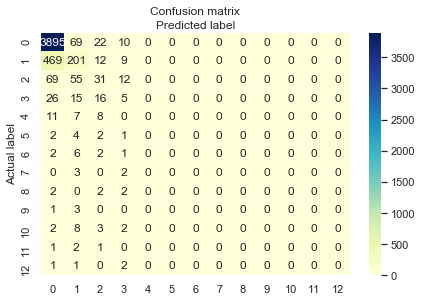

In [25]:
#Defining training and testing groups
x_train, x_test, y_train, y_test = train_test_split(features_hc, target, test_size = 0.5, random_state = 4)

#Training the model previously defined
dtc.fit(x_train, y_train)

#Obtaining and printing out results from the model (Confusion Matrix)
predicted = dtc.predict(x_test)
cm = metrics.confusion_matrix(y_test,predicted)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

#Printing the numerical result of the confusion matrix
print("\n Accuracy score: {:.5f}".format(dtc.score(x_test, y_test)))
misclassification_error = (FP + FN) / float(TP + TN + FP + FN)
print("\n Misclassification Rate: {:.5f}".format(misclassification_error))
sensitivity = TP / float(FN + TP)
print("\n True Positive Rate: {:.5f}".format(sensitivity))
specificity = TN / (TN + FP)
print("\n True Negative Rate: {:.5f}".format(specificity))
precision = TP / float(TP + FP)
print("\n Precision : {:.5f}".format(precision))
prevalence =  float(FN + TP)/float(TP + TN + FP + FN)
print("\n Prevalence : {:.5f}".format(prevalence))
fscore = (2 * precision * sensitivity) / (precision + sensitivity)
print("\n F score : {:.5f}".format(fscore))
print("\n False Positive Rate: {:.5f}".format(1-specificity))

In [26]:
#Repeat with KFold - creating groups
kf = KFold(n_splits = 5, random_state = 4, shuffle = True)


#Repeat with KFold - Training model (previously defined) and obtaining its output
kFoldTotal = 0
for k, (train_index, test_index) in enumerate(kf.split(features_hc)):
    x_train, x_test = features_hc.iloc[train_index], features_hc.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    dtc.fit(x_train, y_train)
    kFoldTotal += dtc.score(x_test, y_test)
    print("[fold {0}] score: {1:.5f}".format(k, dtc.score(x_test, y_test)))

#Printing out the results
roundedTotal = round(kFoldTotal/5, 5)
print("\nKNN mean score [5 folds] = " + str(roundedTotal))

[fold 0] score: 0.83150
[fold 1] score: 0.83600
[fold 2] score: 0.82150
[fold 3] score: 0.83150
[fold 4] score: 0.83450

KNN mean score [5 folds] = 0.831
